# AI Cracks Sarcasm Code
## Introduction

Our project aims to shed light on the comparative strengths of bidirectional Long Short-Term Memory (LSTM) and Bidirectional Encoder Representations from Transformers (BERT) in sarcasm detection within news headlines. Transformers have excelled in text analysis tasks using bidirectional context, efficient parallelization, attention mechanisms, and pretrained representations. However, there has been some findings suggested that bidirectional LSTM’s can achieve better results than BERT on small datasets and the simple models are usually trained in less time. Therefore, the performance of a model can be dependent on the task and the data. For that reason, we are going to split the data into short and long headlines and analyse the performances of LSTM and BERT models in this project.

# 1. Downloading packages

In [47]:
import json, os
import pandas as pd

# Data Preprocessing
import numpy as np
%pip install transformers
import re, nltk, string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# for LSTM
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
import keras
from gensim.models import KeyedVectors
import random


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# 2. Reading in data

#### About our data
News Headlines Dataset contains headlines from two news websites: “The Onion” aims at producing sarcastic versions of current events (14K headlines), whereas “HuffPost” publishes real news (15K headlines). 

Link: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

In [48]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines = True)

In [49]:
data.head() # check the data

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [50]:
data.drop(columns="article_link", axis=1, inplace=True) # drop the column containing article links since we don't need them in our analysis
data.head(5)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [51]:
data["headline"][0]

'thirtysomething scientists unveil doomsday clock of hair loss'

# 3. Preprocessing data

To test the performance of models on short and long sentences, the original dataset had to be split based on sentence length. Upon visual inspection of the distribution of data (see the scatterplots below), potential outliers were identified, and finally excluded if their lengths exceeded 25 words. Afterwards, data was split according to the median, which resulted in a shorter sentences dataset with less or equal to 10 words, and longer sentences with more than 10 words and less or equal to 25 words. An equal distribution of sarcastic and non-sarcastic headlines was also considered during the split into these two conditions. The following sections introduce data cleanup considerations, inspection of data distirbution and data split in details.

## 3.1. Data cleanup

After inspecting the dataset, we came to a conclusion that there were some duplicate headlines in the dataset that had to be removed in order not to confound the results of classification later. Duplicates were identified and then removed.

In [53]:
data = pd.DataFrame(data)

# Inspect whether the are duplicates
len(data['headline'])-len(data['headline'].drop_duplicates())

# Remove duplicates
data = data.drop_duplicates(subset = 'headline')
data.describe()

,is_sarcastic
count,28503.000000
mean,0.475459
std,0.499406
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## 3.2. Inspecting sentences length
In order to divide the dataset into the short and long conditions, we first had to inspect data and see what kind of split made the most sense. The following sections explain our reasoning and procedure step by step.

### 3.2.1. Tokenization and number of words
To measure the length of each sentence, we first had to tokenize them in order to be able to count words. We then created a length variable and sorted by length, to see how the length of sentences is distributed.

In [54]:
tokenize = Tokenizer(oov_token="<oov>") # creating Keras Tokenizer object
tokenize.fit_on_texts(data['headline']) # build the vocabulary based on the unique words in X_long
word_idx = tokenize.word_index #  mapping words to their respective integer indices, from the fitted tokenizer
data['headline_sequence'] = tokenize.texts_to_sequences(data['headline']) # convert headlines into integer sequences using the word index
data['length'] = data['headline_sequence'].apply(len) # calculate the number of words in each headline

In [57]:
data = data.sort_values(by='length')
data.head()

,is_sarcastic,headline,headline_sequence,length
27120,0,explosive illusions,"[7127, 15685]",2
21220,0,another opportunity,"[208, 2264]",2
1566,1,willow rented,"[11866, 5736]",2
17383,1,ant born,"[7245, 1960]",2
17980,0,magical marseille,"[1467, 25325]",2


In [58]:
data.tail() # we can see one huge outlier consisting of 152 words

,is_sarcastic,headline,headline_sequence,length
20776,0,"'how do we treat the little people, joan?' i a...","[4544, 97, 94, 2385, 4, 159, 67, 3268, 70, 82,...",31
23598,0,occasionally you realize someone you thought w...,"[15801, 20, 1598, 510, 20, 482, 75, 7, 1510, 3...",38
24815,1,"elmore leonard, modern prose master, noted for...","[28847, 7824, 1530, 9443, 3399, 11386, 6, 31, ...",39
16588,1,"'12 years a slave,' 'captain phillips,' 'ameri...","[15162, 104, 7, 5118, 70, 6034, 24623, 70, 213...",40
7302,1,hot wheels ranked number one toy for rolling d...,"[420, 3348, 6462, 818, 43, 2634, 6, 3273, 78, ...",152


##  3.3. Visual inspection
After inspecting data visually, we can see that vast majority of data is under 20 words long. Another benchmark we can see is 25 words, after whcih we only see a few examples of sentences that are much longer. Based on this we decided to consider sentences of 25+ words outliers, and remove them from the dataset.

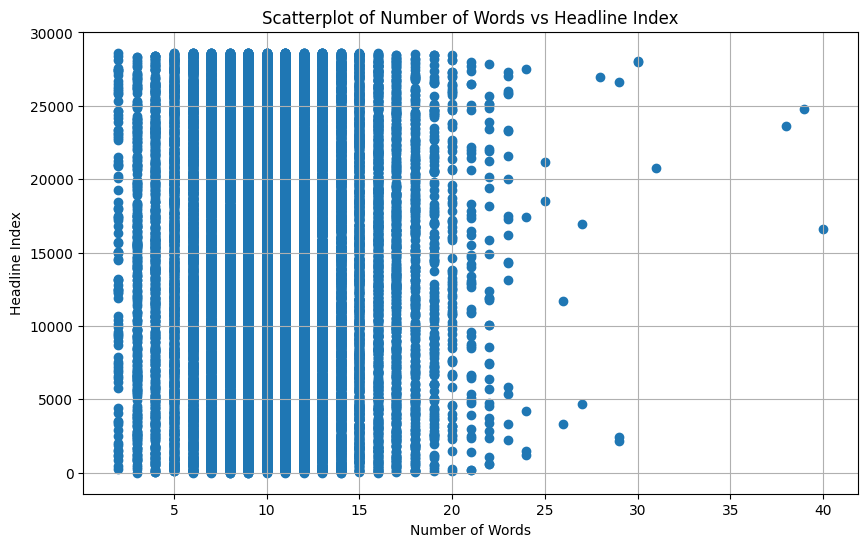

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(data['length'], data.index)
plt.title('Scatterplot of Number of Words vs Headline Index')
plt.xlabel('Number of Words')
plt.ylabel('Headline Index')
plt.grid(True)
plt.show()

In [62]:
# we wil condider headlines longer than 25 words as outliers and thus remove them
data_clean = data[data['length'] <= 25]

# the removal of outlier has no significant consequences for data characteristics
print(data_clean.groupby("is_sarcastic").describe()) 

               length                                                 
                count       mean       std  min  25%   50%   75%   max
is_sarcastic                                                          
0             14947.0   9.967351  2.897856  2.0  8.0  10.0  12.0  25.0
1             13541.0  10.578835  3.659179  2.0  8.0  10.0  13.0  25.0


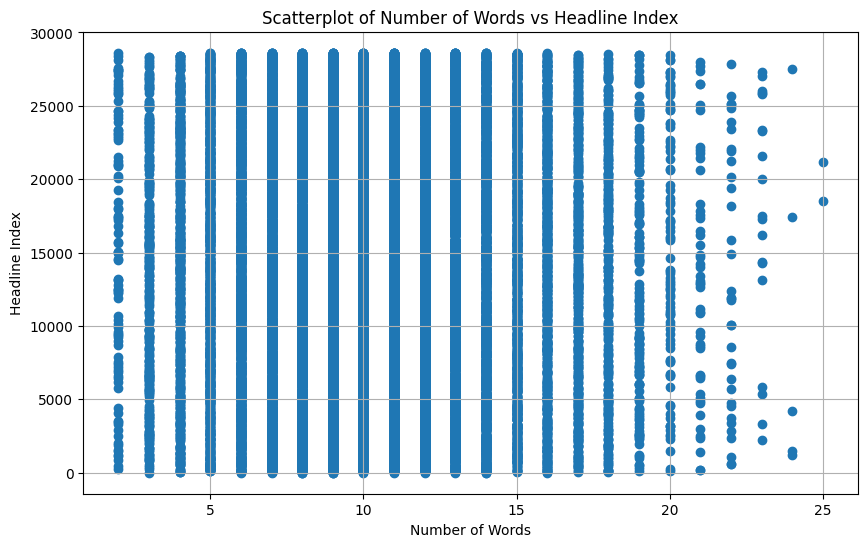

In [63]:
# plot the scatterplot again, now without the outliers
plt.figure(figsize=(10, 6))
plt.scatter(data_clean['length'], data_clean.index)
plt.title('Scatterplot of Number of Words vs Headline Index')
plt.xlabel('Number of Words')
plt.ylabel('Headline Index')
plt.grid(True)
plt.show()

## 3.4. Splitting data into short headlines dataset and long headlines dataset

After removing outliers, we split data in half according to the median. This resulted in two subsets of data: short sentences with sentences no longer than 10 words and long sentences with length of 11 to 25 words.

In [64]:
data_clean['length'].median()

data_short = data_clean[data_clean['length'] <= data_clean['length'].median()]
data_long = data_clean[data_clean['length'] > data_clean['length'].median()]

print(data_short.groupby("is_sarcastic").describe(), data_long.groupby("is_sarcastic").describe())

              length                                               
               count      mean       std  min  25%  50%   75%   max
is_sarcastic                                                       
0             8386.0  7.959218  1.905585  2.0  7.0  8.0  10.0  10.0
1             7105.0  7.757635  1.830771  2.0  7.0  8.0   9.0  10.0               length                                                   
               count       mean       std   min   25%   50%   75%   max
is_sarcastic                                                           
0             6561.0  12.534065  1.657422  11.0  11.0  12.0  13.0  25.0
1             6436.0  13.693288  2.446206  11.0  12.0  13.0  15.0  25.0


## 3.5. Splitting data into X and Y
Last step before proceeding with model training was to separate the headlines (X) from the labels (Y) for both short and long data.

In [65]:
X_long = data_long['headline']
label_long = to_categorical(data_long["is_sarcastic"], 2)

X_short = data_short['headline']
label_short = to_categorical(data_short['is_sarcastic'], 2)

In [66]:
data_long # check the data

,is_sarcastic,headline,headline_sequence,length
23964,0,"in 'margaritaville,' broadway's lisa howard fi...","[5, 28416, 70, 14820, 4960, 3101, 109, 2831, 9...",11
12439,0,"arcade fire, bon iver, strokes form supergroup...","[22513, 309, 7655, 22514, 10965, 1514, 14477, ...",11
10195,0,club for growth attacks donald trump with new ...,"[1300, 6, 3047, 569, 54, 13, 10, 12, 2758, 5, ...",11
7922,0,proof that human alex jones is most certainly ...,"[1963, 26, 359, 2550, 1140, 11, 99, 10494, 29,...",11
22797,1,90% of audience at college graduation involved...,"[1604, 3, 841, 15, 212, 3448, 3624, 5, 7646, 9...",11
...,...,...,...,...
1449,1,man at park who set up table full of water cup...,"[14, 15, 962, 37, 488, 22, 866, 362, 3, 426, 3...",24
17412,1,house chaplain delivers soulful prayer for god...,"[69, 8045, 1705, 10655, 4823, 6, 252, 2, 469, ...",24
4182,1,high school kicker finds it helpful to imagine...,"[158, 100, 12608, 109, 27, 6058, 2, 3491, 912,...",24
18517,1,"unearthed cave painting of wooly mammoth, sabe...","[15419, 4635, 4660, 3, 25625, 25626, 15420, 53...",25


# 4. Model training

In order to test the performance of the LSTM and BERT models on long versus short sentences data, we decided to train a total of four models: LSTM on short setnecnes, on long sentences, BERT on short sentences and BERT on long sentences. The following sections address both model building and training processes in more detail.

## 4.1. Bidirectional LSTM

Bidirectional LSTM is a type of recurrent neural network architecture used in natural language processing. Unlike traditional LSTMs, bidirectional LSTMs process input sequences in both forward and backward directions, enabling the model to capture information from both past and future context, which makes it well-suited for tasks like sarcasm detection.

### 4.1.1. Data Preparation

First, to conform to model requirements, we ensure that the sarcasm labels have dimensions (None, 1). This ensures compatibility with downstream processes.


In [68]:
Y_long = data_long["is_sarcastic"] 
Y_short = data_short['is_sarcastic']

We use the pad_sequences() function to ensure uniform length of headline integer sequences, a prerequisite for LSTM processing. Integer sequences representing words are padded to match the length of the longest headline, accommodating variations in sentence lengths. Еhat is, short sentences will be padded to the length of 10 integers, while long healines will be padded to the length of 25 integers. Following this preprocessing step, the dataset is split into training and testing sets, maintaining the original class distribution for sarcasm labels.

In [ ]:
X_long_padded = pad_sequences(data_long['headline_sequence'], padding="pre") 

X_long_train, X_long_test, y_long_train, y_long_test = train_test_split(
    X_long_padded, 
    Y_long,
    random_state = 0,  # seed for reproducibility
    stratify = Y_long  # ensures that the class distribution is maintained in splits
)

Now, let's apply the same sequence padding and data splitting steps to the short headlines dataset.

In [ ]:
X_short_padded = pad_sequences(data_short['headline_sequence'], padding="pre")

X_short_train, X_short_test, y_short_train, y_short_test = train_test_split(
    X_short_padded, 
    Y_short,
    random_state=0,  # seed for reproducibility
    stratify=Y_short  # ensures that the class distribution is maintained in splits
    )

### 4.1.2. Embeddings

To capture nuanced semantic relationships in headlines, we employ 200-dimensional GloVe embeddings, leveraging their ability to offer contextually rich word representations. That is, each of the 30,885 unique words in the headlines, as indicated by the word_idx, will be represented by a set of 200 numbers in the GloVe embeddings. First, let's load a file with Glove embeddings and create an embeddings dictionary.

In [69]:
embeddings_file = 'glove.twitter.27B.200d.txt' 

def get_coefs(word, *array): # function to parse lines in the embeddings file
    return word, np.asarray(array, dtype='float32')

with open(embeddings_file, 'r', encoding='utf-8') as f: # opens the txt file in read mode with UTF-8 encoding
    embeddings_dict = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in f) # for each line from the file, strip any trailing whitespaces, splits the line into a list of values, uses get_coefs 

To illustrate the structure of the resulting embeddings dictionary, consider the example:

In [70]:
embeddings_dict['sarcasm'] 

array([ 5.5789e-01,  1.2894e-01,  5.8807e-02, -1.7184e-01, -2.1062e-01,
        6.2724e-01,  3.8536e-01, -8.4433e-02, -1.1365e+00,  2.3821e-02,
        5.3795e-02, -6.7236e-01, -3.0422e-01,  1.1528e+00, -2.6915e-01,
        3.8259e-01, -3.9516e-01,  1.7018e-01, -1.1841e-01, -1.2170e+00,
       -2.3860e-01,  1.9965e-01,  3.4177e-01, -5.6872e-01,  3.4706e-01,
        1.4325e+00, -1.4076e-01, -5.2220e-01, -1.0320e-01, -2.6111e-01,
        3.5777e-01,  3.6756e-02, -4.0606e-01, -8.5759e-01,  2.4264e-01,
        1.2333e-02,  3.2333e-01, -5.5376e-02,  9.6043e-02,  2.3453e-01,
        1.2113e+00, -1.3714e-03,  4.8227e-01, -3.6788e-02,  6.1119e-01,
        4.1280e-01,  1.8004e-01,  1.0982e+00, -3.9601e-02, -5.0017e-01,
        6.3369e-01,  3.3001e-01,  8.4009e-03, -9.1504e-01,  8.9476e-01,
       -3.5948e-01, -6.0683e-01, -1.2135e-01, -7.2819e-01,  1.7653e-01,
       -5.3398e-01,  2.9630e-01, -1.1180e+00,  2.0071e-01,  8.2873e-02,
       -2.5766e-01, -7.1431e-01,  1.7063e-01, -1.0573e+00,  3.07

Here, 'sarcasm' serves as a key, and the associated value is a 200-dimensional embedding representing the semantic context of the word.

To create an embeddings matrix for LSTM models, summary statistics of the embedding values are calculated. The mean, standard deviation, and size of the embeddings are computed using the obtained GloVe embeddings.

In [71]:
all_embs = np.stack(list(embeddings_dict.values())) # stack the word embeddings into a single NumPy array
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_size = all_embs.shape[1] # dimensionality of the word embeddings that we chose, i.e., 200

print(emb_mean)
print(emb_std)
print(emb_size) 

0.009065018
0.4428109
200


30885

This code segment focuses on initializing the embeddings matrix, a crucial component serving as weights in LSTM models. The matrix dimensions are determined by the number of unique words and the chosen embedding size.

In [72]:
max_tokens = 35000 # the maximum number of unique tokens to consider
unique_words = min(max_tokens, len(word_idx)) #  the number of unique words to be considered in our case
unique_words = len(word_idx) + 1  # add 1 for the out-of-vocabulary token

embedding_matrix = np.random.normal(emb_mean, emb_std, (unique_words, emb_size)) #  initialize matrix with random values drawn from a normal distribution. The matrix has dimensions [unique_words, emb_size]
for word, i in word_idx.items(): 
    if i >= unique_words: continue # only 30886 are going to be considered
    embedding_vector = embeddings_dict.get(word) # retrieve embedding vector for current word
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector 

In [73]:
print(embedding_matrix[0,:]) # 200 dimentions for first word (first row)
print(embedding_matrix.shape) # 30886 unique words, 200 dimentions

[-0.17020442  0.03116847 -1.07582817  0.36186248  0.4180253  -0.3219776
 -0.20197076  0.42603129  0.67458383  0.07333636  0.07449753 -0.06629721
  0.81789463 -0.50708413  0.95065257  0.18501806  0.63000263 -0.36315687
 -0.26701328 -0.01585692 -0.16559253 -0.17668119  0.304341    0.33229908
  0.02107965 -0.91741545 -0.36308125  0.07217352  0.26530909 -0.38634705
 -0.20151531  0.25827646 -0.83617935 -0.23924373 -0.12564975  0.58610854
  0.06877793 -0.24593499 -0.11890545 -0.48246299 -0.31018963 -0.52144423
  0.12041138  0.00525049  0.40656141  0.2462752  -0.13689273  0.00288476
  0.18495035  0.06798452 -0.79361955  0.6587992  -0.0147079  -0.10794832
 -0.4248695  -0.07909448 -0.67929885  0.09074037  0.08306787 -0.23388365
  0.40438204 -0.47164171  0.60118333  0.48494016  0.67520364  0.05173064
 -0.11764901 -0.54257349 -0.01547647 -0.05349289  0.3527546  -0.06080202
  0.42060899  0.39494958 -0.35699771  0.60528014  0.54492745  0.3015073
  0.66159255 -0.11433128  0.2418502  -0.34741939  0.0

###  4.1.3. Building models

We are now all set for building two distinctive models to handle long and short headlines. The only difference between these models lies in the input length defined within the embedding layer, stemming from the differing padding applied to the long vs. short headlines data. First, we create the model tailored for long headlines, followed by the model for short ones.

In [ ]:
random.seed(2023)
model_long = Sequential()
model_long.add(Embedding(input_dim = unique_words, 
                    output_dim = emb_size, 
                    weights = [embedding_matrix], 
                    input_length = 25, # each sentence was padded to the length of 25 tokens
                    trainable = True))
model_long.add(Bidirectional(LSTM(units = 128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model_long.add(Dense(1, activation = 'sigmoid')) # binary classification

model_long.compile(optimizer=keras.optimizers.legacy.Adam(lr = 0.01), loss = 'binary_crossentropy', metrics = ['acc'])

In [74]:
random.seed(2023)
model_short = Sequential()
model_short.add(Embedding(input_dim = unique_words, 
                    output_dim = emb_size, 
                    weights = [embedding_matrix], 
                    input_length = 10, # each sentence was padded to the length of 10 tokens
                    trainable = True))
model_short.add(Bidirectional(LSTM(units = 128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model_short.add(Dense(1, activation = 'sigmoid')) # binary classification

model_short.compile(optimizer=keras.optimizers.legacy.Adam(lr = 0.01), loss = 'binary_crossentropy', metrics = ['acc'])

/Users/ninakoperska/VS_projects/venv/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 4.1.4. Training

Here we train the model using the long headlines data, and then we repeat the same training process with the short headlines data.

In [75]:
# Train long headlines dataset
history_long = model_long.fit(
    X_long_train,
    y_long_train,
    batch_size = 128,
    validation_data = (X_long_test, y_long_test),
    epochs = 2
)

Epoch 1/2
77/77 [==============================] - 13s 142ms/step - loss: 0.4754 - acc: 0.7692 - val_loss: 0.2733 - val_acc: 0.8892
Epoch 2/2
77/77 [==============================] - 12s 158ms/step - loss: 0.1580 - acc: 0.9402 - val_loss: 0.3256 - val_acc: 0.8892


In [76]:
# Train short headlines dataset
history_short = model_short.fit(
    X_short_train,
    y_short_train,
    batch_size = 128,
    validation_data = (X_short_test, y_short_test),
    epochs=2)

Epoch 1/2
91/91 [==============================] - 7s 59ms/step - loss: 0.4426 - acc: 0.7921 - val_loss: 0.3178 - val_acc: 0.8580
Epoch 2/2
91/91 [==============================] - 7s 75ms/step - loss: 0.1380 - acc: 0.9484 - val_loss: 0.3922 - val_acc: 0.8533


### 4.1.5. Validation set

The final validation accuracies are calculated for both the short and long headline models.

In [77]:
# For newer versions of Keras/TensorFlow
lstm_short_val_acc = round(history_short.history['val_acc'][-1]*100, 2)
lstm_long_val_acc = round(history_long.history['val_acc'][-1]*100, 2)

# Print the final validation accuracies
print(lstm_short_val_acc, lstm_long_val_acc)

85.33 88.92


## 4.2. BERT-Base

### 4.2.1. BERT-specific data preparation

In [78]:

## DATA SPILITTING

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'headline' is the feature and 'is_sarcastic' is the label column
X_long = data_long['headline']
Y_long = data_long['is_sarcastic']
X_short = data_short["headline"]
Y_short = data_short['is_sarcastic']

# Split the data into training and testing sets
X_long_train, X_long_test, Y_long_train, Y_long_test = train_test_split(X_long, Y_long, test_size=0.2)
X_short_train, X_short_test, Y_short_train, Y_short_test = train_test_split(X_short, Y_short, test_size=0.2)

# Use LabelEncoder to convert labels to integers (0 or 1)
label_encoder = LabelEncoder()
Y_long_train_encoded = label_encoder.fit_transform(Y_long_train)
Y_long_test_encoded = label_encoder.transform(Y_long_test)
Y_short_train_encoded = label_encoder.fit_transform(Y_short_train)
Y_short_test_encoded = label_encoder.transform(Y_short_test)


### 4.2.2. Tokenization for BERT
Similarly, we had to perform a separate tokenization of inputs for the BERT model, to create inputs that correspond with the requirements of the transformer. Below, a custom encoder function was built to split the healdines into words and turn the input into a BERT-friendly format.

In [79]:
#BERT TOKENIZATION
pretrained = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

In [80]:

#tokenization
x_long_train_ids = encoder(X_long_train)
x_long_test_ids = encoder(X_long_test)
x_short_train_ids = encoder(X_short_train)
x_short_test_ids = encoder(X_short_test) 


#DATA TRANSFORMATION

#converting arrays to tensors
#long headlines
x_long_train_ids = tf.convert_to_tensor(x_long_train_ids)
x_long_test_ids = tf.convert_to_tensor(x_long_test_ids)
y_long_test = tf.convert_to_tensor(Y_long_test_encoded)
y_long_train = tf.convert_to_tensor(Y_long_train_encoded)

#short headlines
x_short_train_ids = tf.convert_to_tensor(x_short_train_ids)
x_short_test_ids = tf.convert_to_tensor(x_short_test_ids)
y_short_test = tf.convert_to_tensor(Y_short_test_encoded)
y_short_train = tf.convert_to_tensor(Y_short_train_encoded)

/Users/ninakoperska/VS_projects/venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### 4.2.3. Building the models
To ensure that the long and short sentences models are trained seperately, the same model has been specified twice. This way we could make sure that the model that is trained second doesn't use any of the objects that were trained by the previous model and the memory is fully reset. We also made the decision to freeze the pre-trained BERT encoder, and by doing this greatly reduced the number of trainable parameters. This decision had little impact on final accuracy and a huge positive influence on the speed of training. After several tuning attempts of hyperparametrs such as learning rate, dropout, epochs and batch sizes, we have decided to opt for the parameters specified below. It can be noted that for example the learning rate of this model is much lower than that of LSTM. In general, similar projects as this one use very low learning rates for transformers. The reason we used the BERT-Base model is that it has proven to be a robust and effective choice for a wide range of applications and the model's capacity to capture complex relationships in language makes it suitable for our project. Moreover, in our project we wanted to compare the LSTM to a version of BERT model where we would spend less time in extensive fine-tuning process therefore we used the a pre-trained Base version of it. The choice for our model selection inspired by a study conducted by Ezen-Can (2020), which made a direct comparison between LSTM and the base model of BERT, where they observed significantly better results for LSTM in a small dataset. Finally, we wanted to add our bert model a dense layer with 128 units with ReLu function in order to introduce non-linearity to the model to capture complex patterns in the data. Then, we added a dropout layer with 0.2 dropout rate to mitigate overfitting during the training process. Lastly, we added a final output layer with sigmoid activation function due to the fact that we are doing a binary classification. This architecture has demonstrated efficacy in achieving strong performance on similar natural language processing tasks (https://www.kaggle.com/code/raghavkhemka/sarcasm-detection-using-bert-92-accuracy).


#### Long sentences BERT model

In [81]:
#model building with bert (version 12 layer, 768 hidden, 12 heads)

bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output) 

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [82]:
bert_encoder.trainable = False

In [83]:
model.compile(tf.keras.optimizers.legacy.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer  [(None, 16)]              0         
 )                                                               
                                                                 
 tf_bert_model_5 (TFBertMod  TFBaseModelOutputWithPo   109482240 
 el)                         olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 16, 768),                        
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                 

In [84]:
#long model
long_model = model.fit(x = x_long_train_ids, y = y_long_train, epochs = 5, verbose = 1, batch_size = 32, validation_data = (x_long_test_ids, y_long_test))


Epoch 1/5
325/325 [==============================] - 118s 353ms/step - loss: 0.7021 - accuracy: 0.5425 - val_loss: 0.6295 - val_accuracy: 0.6865
Epoch 2/5
325/325 [==============================] - 121s 374ms/step - loss: 0.6425 - accuracy: 0.6277 - val_loss: 0.5750 - val_accuracy: 0.7458
Epoch 3/5
325/325 [==============================] - 120s 370ms/step - loss: 0.6028 - accuracy: 0.6817 - val_loss: 0.5384 - val_accuracy: 0.7715
Epoch 4/5
325/325 [==============================] - 121s 373ms/step - loss: 0.5791 - accuracy: 0.7087 - val_loss: 0.5132 - val_accuracy: 0.7762
Epoch 5/5
325/325 [==============================] - 125s 386ms/step - loss: 0.5609 - accuracy: 0.7204 - val_loss: 0.4931 - val_accuracy: 0.7981


#### Short sentences model BERT

In [85]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)
bert_encoder.trainable = False

model.compile(tf.keras.optimizers.legacy.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [86]:
#short model
short_model = model.fit(x = x_short_train_ids, y = y_short_train, epochs = 5, verbose = 1, batch_size = 32, validation_data = (x_short_test_ids, y_short_test))

Epoch 1/5
388/388 [==============================] - 161s 404ms/step - loss: 0.4874 - accuracy: 0.7738 - val_loss: 0.3857 - val_accuracy: 0.8216
Epoch 2/5
388/388 [==============================] - 153s 394ms/step - loss: 0.4418 - accuracy: 0.7991 - val_loss: 0.3993 - val_accuracy: 0.8170
Epoch 3/5
388/388 [==============================] - 158s 406ms/step - loss: 0.4301 - accuracy: 0.8026 - val_loss: 0.3589 - val_accuracy: 0.8367
Epoch 4/5
388/388 [==============================] - 162s 417ms/step - loss: 0.4127 - accuracy: 0.8073 - val_loss: 0.3366 - val_accuracy: 0.8545
Epoch 5/5
388/388 [==============================] - 160s 412ms/step - loss: 0.4024 - accuracy: 0.8158 - val_loss: 0.3360 - val_accuracy: 0.8490


### 4.2.4. Testing accuracies

In [87]:
#model summaries
# Accessing training and validation accuracy and loss values for the long model
long_train_accuracy = long_model.history['accuracy']
long_val_accuracy = long_model.history['val_accuracy']
long_train_loss = long_model.history['loss']
long_val_loss = long_model.history['val_loss']

# Accessing training and validation accuracy and loss values for the short model
short_train_accuracy = short_model.history['accuracy']
short_val_accuracy = short_model.history['val_accuracy']
short_train_loss = short_model.history['loss']
short_val_loss = short_model.history['val_loss']

### 4.2.5. Confusion matrix

 The confusion matrix is a useful tool for evaluating the performance of a classification model and it provides a summary of predicted versus actual class labels.  The confusion matrix below summarizes the performance of the short model in distinguishing between sarcastic and non-sarcastic headlines.

97/97 [==============================] - 32s 321ms/step
Confusion Matrix:
[[1400  284]
 [ 184 1231]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86      1684
           1       0.81      0.87      0.84      1415

    accuracy                           0.85      3099
   macro avg       0.85      0.85      0.85      3099
weighted avg       0.85      0.85      0.85      3099



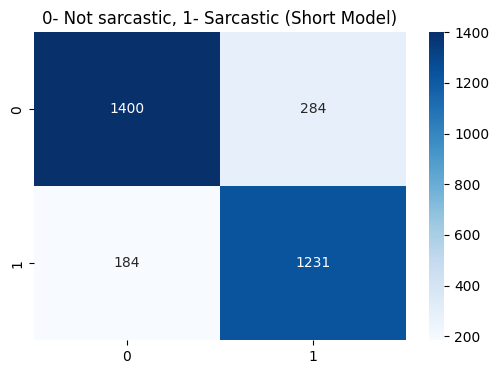

In [88]:
#confusion matrix for short
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on the test set using the original short model
y_short_pred = model.predict(x_short_test_ids)
y_short_pred_classes = (y_short_pred > 0.5).astype('int')  # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix for the short model
conf_matrix_short = confusion_matrix(y_short_test, y_short_pred_classes)

# Print confusion matrix for the short model
print("Confusion Matrix:")
print(conf_matrix_short)

# Calculate and print classification report for the short model
class_report_short = classification_report(y_short_test, y_short_pred_classes)
print("\nClassification Report:")
print(class_report_short)

# Plot confusion matrix for the short model
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_short, annot=True, fmt='d', cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic (Short Model)")
plt.show()

 The confusion matrix below summarizes the performance of the long model in distinguishing between sarcastic and non-sarcastic headlines.

In [2]:
#confusion matrix for long model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions on
y_long_pred = model.predict(x_long_test_ids)
y_long_pred_classes = (y_long_pred > 0.5).astype('int')  # Assuming a binary classification threshold of 0.5

# Calculate confusion matrix
conf_matrix_long = confusion_matrix(y_long_test, y_long_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix_long)

# Calculate and print classification report
class_report = classification_report(y_long_test, y_long_pred_classes)
print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_long,annot=True,fmt='d',cmap='Blues')
plt.title("0- Not sarcastic, 1- Sarcastic")
plt.show()


NameError: name 'model' is not defined

# 5. Performance comparison
Performance of the models was assessed based on accuracy (% of correctly classified cases of the validation set).

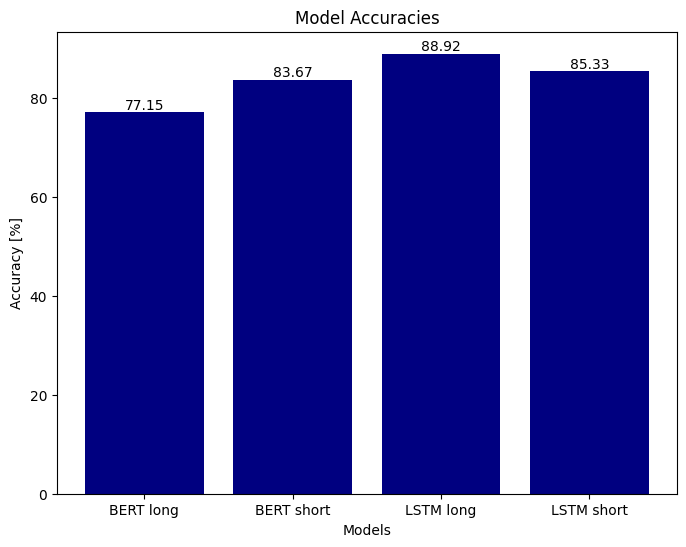

In [90]:
import matplotlib.pyplot as plt

# Sample accuracy values for four models
accuracies = [long_val_accuracy[2] * 100, short_val_accuracy[2] * 100, lstm_long_val_acc, lstm_short_val_acc]  # Replace these with your actual accuracy values

# Labels for each model
labels = ['BERT long', 'BERT short', 'LSTM long', 'LSTM short']

# Create a bar chart
plt.figure(figsize=(8, 6))  # Set the size of the plot
bars = plt.bar(labels, accuracies, color='navy')  # Plot bars with labels and accuracy values

# Adding data labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding title and labels
plt.title('Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy [%]')

# Display the plot
plt.show()


In [91]:
# Accessing training and validation accuracy and loss values for the long model
long_train_accuracy = long_model.history['accuracy']
long_val_accuracy = long_model.history['val_accuracy']
long_train_loss = long_model.history['loss']
long_val_loss = long_model.history['val_loss']

# Accessing training and validation accuracy and loss values for the short model
short_train_accuracy = short_model.history['accuracy']
short_val_accuracy = short_model.history['val_accuracy']
short_train_loss = short_model.history['loss']
short_val_loss = short_model.history['val_loss']

# Print summaries
print("\nShort Model Summary:")
print("Training Accuracy:", short_train_accuracy[-1])
print("Validation Accuracy:", short_val_accuracy[-1])
print("Training Loss:", short_train_loss[-1])
print("Validation Loss:", short_val_loss[-1])

print("Long Model Summary:")
print("Training Accuracy:", long_train_accuracy[-1])
print("Validation Accuracy:", long_val_accuracy[-1])
print("Training Loss:", long_train_loss[-1])
print("Validation Loss:", long_val_loss[-1])


Short Model Summary:
Training Accuracy: 0.8157682418823242
Validation Accuracy: 0.8489835262298584
Training Loss: 0.402426153421402
Validation Loss: 0.336025208234787
Long Model Summary:
Training Accuracy: 0.7204000949859619
Validation Accuracy: 0.7980769276618958
Training Loss: 0.5609337091445923
Validation Loss: 0.4931066334247589


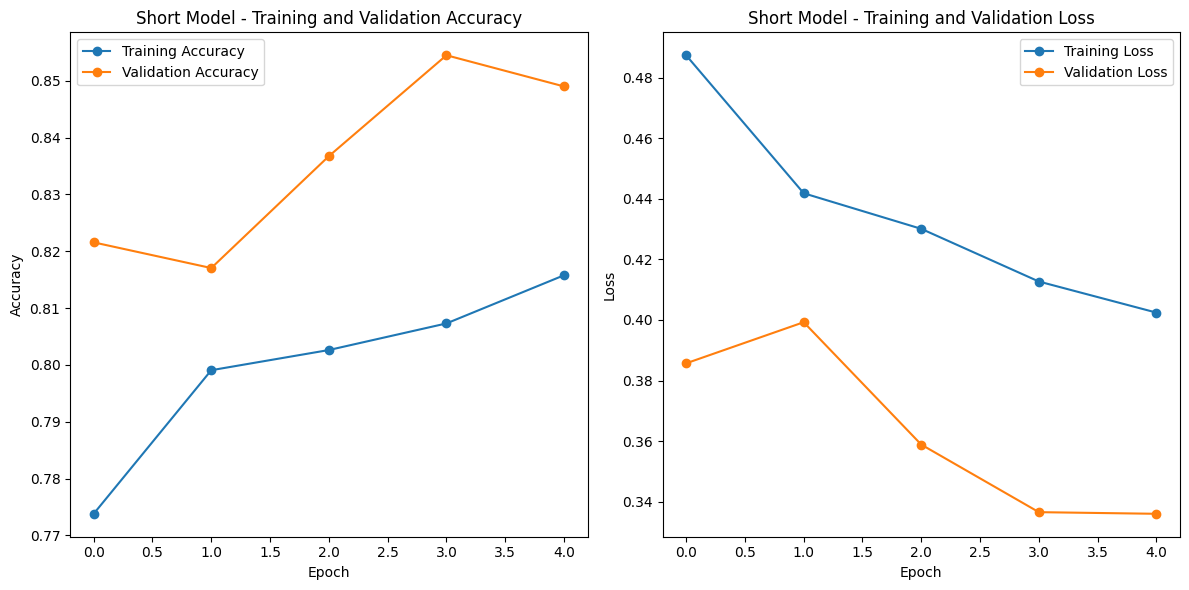

In [92]:
# SHORT MODEL
# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(short_train_accuracy, label='Training Accuracy', marker='o')
plt.plot(short_val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Short Model - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(short_train_loss, label='Training Loss', marker='o')
plt.plot(short_val_loss, label='Validation Loss', marker='o')
plt.title('Short Model - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()